# 🔍 Predicting Item Prices from Descriptions (Part 3)

# 🔧 **Part 3: Fine-Tuning GPT-4o Mini**

In this final phase, we take GPT-4o Mini and fine-tune it on our curated dataset of item descriptions and prices.
- 🎯 Objective: Fine-tune GPT-4o Mini on our dataset to improve price prediction accuracy.
- 📊 We’ll Compare: Its fine-tuned performance vs. zero-shot results, traditional ML, frontier LLMs, and Ed's human estimates.
- ❓ Key Question: Can GPT-4o Mini beat its own zero-shot baseline — and close the gap with bigger models?

⚙️ Hardware: ✅ CPU is sufficient — no GPU required

🛠️ Requirements: 🔑 Open API Key

📢 Find more LLM notebooks on my GitHub repository: https://github.com/lisek75/nlp_llms_notebook

In [25]:
# imports

import os, sys, pickle, importlib, json, re
from dotenv import load_dotenv
from openai import OpenAI

In [2]:
load_dotenv(override=True)

openai_api_key = os.getenv('OPENAI_API_KEY')
if not openai_api_key: print("❌ OPENAI_API_KEY is missing")
    
openai = OpenAI(api_key=openai_api_key)

# 📥 Load Preprocessed Dataset

In [ ]:
# # If you don’t already have the `.pkl` files generated in Part 1,
# # you can load the dataset directly from the Hugging Face Hub.

# # Load dataset from Hugging Face
# from datasets import load_dataset
# dataset = load_dataset("Lizk75/pricer-data")

# # Create data folder if it doesn't exist
# os.makedirs("data", exist_ok=True)

# # Save train split
# with open("data/train.pkl", "wb") as f:
#     pickle.dump(dataset["train"], f)

# # Save test split
# with open("data/test.pkl", "wb") as f:
#     pickle.dump(dataset["test"], f)

In [3]:
# Add helpers path and import Item class
sys.path.append('./helpers')
from helpers import items
from helpers.items import Item

# Load the pickled datasets
with open('data/train.pkl', 'rb') as file:
    train = pickle.load(file)
    
with open('data/test.pkl', 'rb') as file:
    test = pickle.load(file)

# 🛠️ Step 1 : Data Preparation

In [4]:
# OpenAI recommends fine-tuning with populations of 50-100 examples

ft_train = train[:100]
ft_validation = train[100:150]

To fine-tune GPT-4o-mini, OpenAI requires training data in **.jsonl format**. 

`make_jsonl` converts our chat data :

from 

[
  {"role": "system", "content": "You estimate prices of items. Reply only with the price, no explanation"},
  {"role": "user", "content": "How much is this laptop worth?"},
  {"role": "assistant", "content": "Price is $999.00"}
]

into the .jsonl format 

{"messages": [{"role": "system", "content": "You estimate prices of items. Reply only with the price, no explanation"}, {"role": "user", "content": "How much is this laptop worth?"}, {"role": "assistant", "content": "Price is $999.00"}]}


In [5]:
def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": f"Price is ${item.price:.2f}"}
    ]

messages_for(train[0])

[{'role': 'system',
  'content': 'You estimate prices of items. Reply only with the price, no explanation'},
 {'role': 'user',
  'content': 'How much does this cost?\n\nMICR Toner International Compatible Universal Magnetic Ink Cartridge Replacement for HP CF281A 81A Laser Printers M604 M605 M606 M630 MFP\nPrint Checks Like a Pro with MTI Universal MICR Products MTI Universal HP 81A CF281A MICR Toner Cartridge • Quantity 1 Black Toner Cartridge• Magnetic Toner for Check Printing. • Yield 10.5k pages based on 5% coverage, prints 31.5k checks @ 3 per page. Please Note actual yield may vary depending upon the amount of print on the page and other factors. • Compatible Printers the MTI universal HP CF281A MICR cartridge is designed for HP Laser Printers M604dn M604n M605dh M605dn'},
 {'role': 'assistant', 'content': 'Price is $175.00'}]

In [6]:
def make_jsonl(items):
    result = ""
    for item in items:
        messages = messages_for(item)
        messages_str = json.dumps(messages)
        result += '{"messages": ' + messages_str +'}\n'
    return result.strip()

print(make_jsonl(train[:1]))

{"messages": [{"role": "system", "content": "You estimate prices of items. Reply only with the price, no explanation"}, {"role": "user", "content": "How much does this cost?\n\nMICR Toner International Compatible Universal Magnetic Ink Cartridge Replacement for HP CF281A 81A Laser Printers M604 M605 M606 M630 MFP\nPrint Checks Like a Pro with MTI Universal MICR Products MTI Universal HP 81A CF281A MICR Toner Cartridge \u2022 Quantity 1 Black Toner Cartridge\u2022 Magnetic Toner for Check Printing. \u2022 Yield 10.5k pages based on 5% coverage, prints 31.5k checks @ 3 per page. Please Note actual yield may vary depending upon the amount of print on the page and other factors. \u2022 Compatible Printers the MTI universal HP CF281A MICR cartridge is designed for HP Laser Printers M604dn M604n M605dh M605dn"}, {"role": "assistant", "content": "Price is $175.00"}]}


In [7]:
# Convert the items into jsonl and write them to a file

def write_jsonl(items, filename):
    with open(filename, "w") as f:
        jsonl = make_jsonl(items)
        f.write(jsonl)

In [8]:
write_jsonl(ft_train, "data/ft_train.jsonl")
write_jsonl(ft_validation, "data/ft_val.jsonl")

In [9]:
with open("data/ft_train.jsonl", "rb") as f:
    train_file = openai.files.create(file=f, purpose="fine-tune")
with open("data/ft_val.jsonl", "rb") as f:
    validation_file = openai.files.create(file=f, purpose="fine-tune")

In [10]:
train_file

FileObject(id='file-8QyMKQHRPekaJDjgZTh6eh', bytes=95369, created_at=1743708517, filename='ft_train.jsonl', object='file', purpose='fine-tune', status='processed', expires_at=None, status_details=None)

In [11]:
validation_file

FileObject(id='file-8KEv5pCninPnppTBJmkG9C', bytes=47821, created_at=1743708518, filename='ft_val.jsonl', object='file', purpose='fine-tune', status='processed', expires_at=None, status_details=None)

# 🚀 Step 2: Run Fine-Tuning & Monitor with wandb
We will use https://wandb.ai to monitor the training runs

1- Create an API key in wandb

2- Add this key in OpenAI dashboard https://platform.openai.com/account/organization

In [12]:
wandb_integration = {"type": "wandb", "wandb": {"project": "gpt-pricer"}}

In [13]:
# Run the fine tuning

openai.fine_tuning.jobs.create(
    training_file=train_file.id,
    validation_file=validation_file.id,
    model="gpt-4o-mini-2024-07-18",
    seed=42,
    hyperparameters={"n_epochs": 1},
    integrations = [wandb_integration],
    suffix="pricer"
)

FineTuningJob(id='ftjob-tO0YqMQDZHuElNjc1neGCrsk', created_at=1743708520, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-AalSWqvkkoOsbtYdAVNBKdjL', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-8QyMKQHRPekaJDjgZTh6eh', validation_file='file-8KEv5pCninPnppTBJmkG9C', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-pricer', entity=None, name=None, tags=None, run_id='ftjob-tO0YqMQDZHuElNjc1neGCrsk'))], metadata=None, method=Method(dpo=None, supervised=MethodSupervised(hyperparameters=MethodSupervisedHyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1)), type='supervised'), user_provided_suffix='pricer')

In [14]:
job_id = openai.fine_tuning.jobs.list(limit=1).data[0].id
job_id

# Then check your wandb dashboard to view the run of this job ID

'ftjob-tO0YqMQDZHuElNjc1neGCrsk'

In [21]:
# Use this command to track the fine-tuning progress here
openai.fine_tuning.jobs.list_events(fine_tuning_job_id=job_id, limit=2).data

# You'll receive an email notification once fine-tuning is complete

[FineTuningJobEvent(id='ftevent-VrowhJtwinYoD6uJxZq2suFj', created_at=1743708623, level='info', message='Fine-tuning job started', object='fine_tuning.job.event', data=None, type='message'),
 FineTuningJobEvent(id='ftevent-nwxkqkAvZZamMIR4cJFqix1Z', created_at=1743708621, level='info', message='Files validated, moving job to queued state', object='fine_tuning.job.event', data={}, type='message')]

## Step 3 : Test the fine tuned model

In [22]:
ft_model_name = openai.fine_tuning.jobs.retrieve(job_id).fine_tuned_model
ft_model_name

'ft:gpt-4o-mini-2024-07-18:personal:pricer:BIKj9Ku8'

In [26]:
def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

def gpt_ft(item):
    response = openai.chat.completions.create(
        model=ft_model_name, 
        messages=messages_for(item),
        seed=42,
        max_tokens=7
    )
    reply = response.choices[0].message.content
    return get_price(reply)

In [27]:
print(test[0].price)
print(gpt_ft(test[0]))

327.34
404.32


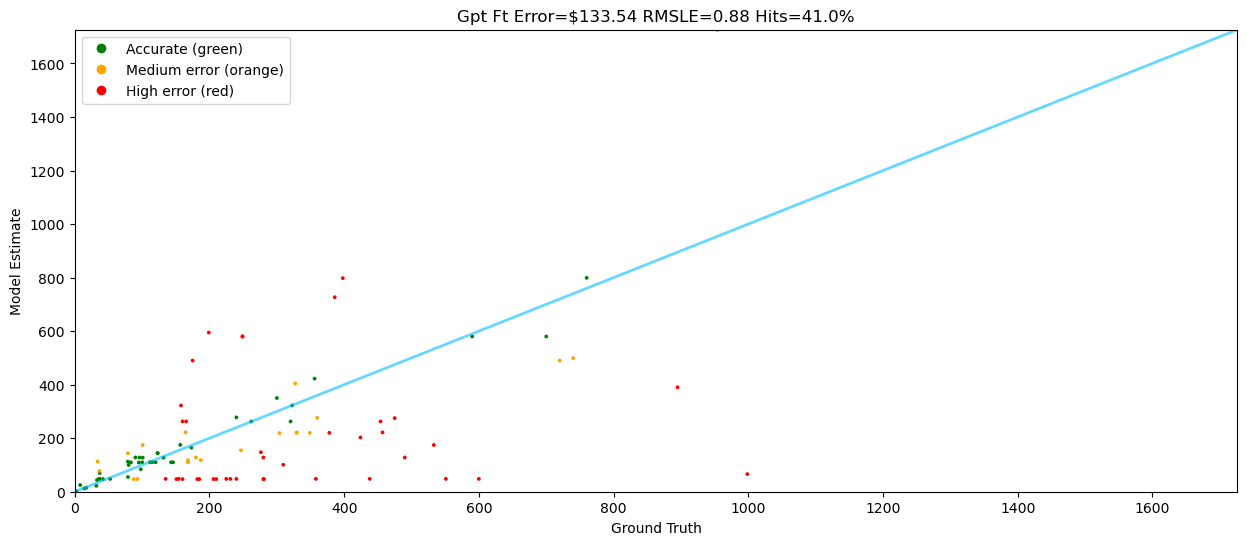

In [29]:
import helpers.testing
importlib.reload(helpers.testing)

from helpers.testing import Tester

tester = Tester(gpt_ft, test[:100])
tester.run()

![](assets/model_performance_comparison.png)

📉 Avrg error increased to 133, meaning the model actually performed worse than its zero-shot version (avrg error = 98)

At first, this was disappointing — but in reality, it was an enriching experiment.
We learned valuable techniques: data curation and cleaning, preparing data for fine-tuning, traditional ML workflows, evaluation metrics, and the complete fine-tuning pipeline for LLMs.

So no regrets — just progress. 💡

⚠️ **When Fine-Tuning Isn't Necessary**:

For this specific task (price prediction from product descriptions), large pre-trained models like GPT-4o already perform well out of the box, thanks to:
- Massive pretraining on diverse data
- Strong generalization ability
- Clear prompting capabilities

👉 In such cases, a **well-crafted prompt** is often more effective and efficient than full fine-tuning.

✅ **When Fine-Tuning Is Worth It (based on OpenAI’s own guidelines)**
- Custom tone/style – e.g., mimicking a brand voice or writing like a specific author
- More consistent output – e.g., always following a strict format
- Fix prompt failures – e.g., when multi-step instructions get ignored
- Handle edge cases – e.g., rare product types or weird inputs
- Teach new tasks – e.g., estimating prices in a custom format no model has seen before

# 🏁 Conclusion
Fine-tuning didn’t boost GPT-4o Mini’s performance for this task — but **the journey was rich.**

📚 We gained hands-on experience, deeper understanding, and clear insight:➡️ For some tasks, **prompting a strong frontier model is more effective than fine-tuning it.**

💡 **Choose fine-tuning only when prompting hits a wall — not by default.**